# Autoregressive Model Testing

## Notes for revision:
- Use ADF to determine if the data is stationary
- If the data is not stationary, use ACF， PACF to determine the difference
- AR(order, difference, moving average), start with order 1
- Issue: negative R^2 meaning the model is not converging

RMSE reduced by: 
- 13.19% by adding Bitcoin volitility in GDP AR prediction
- 10.86% by adding USD Coin volitility in GDP AR prediction


In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [56]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Testing all combinations

In [57]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
order = 1
train_end = '2023-05-01'
train_start = '2017-09-01'

results_list = []

In [58]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'q': 0}
ar_orders['CPI'] = {'p': 1, 'q': 0}
ar_orders['r'] = {'p': 1, 'q': 0}
ar_orders['M1'] = {'p': 1, 'q': 0}
ar_orders['GDP Monthly'] = {'p': 2, 'q': 2}
ar_orders['IM'] = {'p': 3, 'q': 0}
ar_orders['EX'] = {'p': 3, 'q': 0}
ar_orders['CC'] = {'p': 2, 'q': 0}
ar_orders['CC Monthly % Change'] = {'p': 2, 'q': 0}
ar_orders['VIX'] = {'p': 1, 'q': 0}
ar_orders['MOVE'] = {'p': 1, 'q': 0}

ar_orders['vol_LFPR'] = {'p': 1, 'q': 0}
ar_orders['vol_CPI'] = {'p': 1, 'q': 0}
ar_orders['vol_r'] = {'p': 1, 'q': 0}
ar_orders['vol_M1'] = {'p': 1, 'q': 0}
ar_orders['vol_GDP'] = {'p': 1, 'q': 0}
ar_orders['vol_IM'] = {'p': 2, 'q': 1}
ar_orders['vol_EX'] = {'p': 3, 'q': 0}
ar_orders['vol_CC'] = {'p': 1, 'q': 1}

In [59]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

# Pre-difference all macro variables
for vol_macro in vol_macro_list:
    adf_p = adfuller(df[vol_macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{vol_macro}_diff'] = df[vol_macro].diff()
        adf_p = adfuller(df[f'{vol_macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{vol_macro}_diff_diff'] = df[f'{vol_macro}_diff'].diff()


In [60]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

### Check that all macro has been differenced appropriately 

In [61]:
for macro in macro_list:
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro
    check_stationarity(df[target_col]) 

for vol_macro in vol_macro_list:
    available_cols = df.columns
    if f'{vol_macro}_diff_diff' in available_cols:
        target_col = f'{vol_macro}_diff_diff'
    elif f'{vol_macro}_diff' in available_cols:
        target_col = f'{vol_macro}_diff'
    else:
        target_col = vol_macro
    check_stationarity(df[target_col]) 

ADF test for LFPR_diff: p-value = 0.0000
ADF test for CPI_diff_diff: p-value = 0.0000
ADF test for r_diff_diff: p-value = 0.0000
ADF test for M1_diff: p-value = 0.0000
ADF test for GDP Monthly_diff: p-value = 0.0000
ADF test for IM_diff: p-value = 0.0000
ADF test for EX_diff: p-value = 0.0000
ADF test for CC_diff: p-value = 0.0000
ADF test for CC Monthly % Change: p-value = 0.0000
ADF test for VIX: p-value = 0.0005
ADF test for MOVE_diff: p-value = 0.0000
ADF test for vol_LFPR_diff: p-value = 0.0000
ADF test for vol_CPI_diff: p-value = 0.0000
ADF test for vol_r_diff: p-value = 0.0000
ADF test for vol_M1_diff: p-value = 0.0000
ADF test for vol_GDP_diff: p-value = 0.0000
ADF test for vol_IM_diff_diff: p-value = 0.0000
ADF test for vol_EX_diff: p-value = 0.0042
ADF test for vol_CC_diff: p-value = 0.0000


In [62]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [63]:
# variable = 'vol_CC'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

In [70]:
def run_model(df, macro, asset):
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro

    df_temp = df[[target_col, asset]].dropna().copy()
    target = df_temp[target_col]
    exog = df_temp[[asset]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
    p = order_dict['p']
    q = order_dict['q']

    # AR model
    ar_model = SARIMAX(train_endog, order=(p, 0, q))
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 0, q))
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar),
            'Order': f'({p},0,{q})'
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx),
            'Order': f'({p},0,{q})'
        }
    ]

    return metrics

# All Macro & Crypto Combination

In [71]:
results_list = []
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,LFPR,Bitcoin,0.0667,0.1069,0.0000,"(1,0,0)"
1,ARX,LFPR,Bitcoin,0.0696,0.1071,-0.0028,"(1,0,0)"
2,AR,LFPR,Tether,0.0667,0.1069,0.0000,"(1,0,0)"
3,ARX,LFPR,Tether,0.0697,0.1072,-0.0047,"(1,0,0)"
4,AR,LFPR,Litecoin,0.0667,0.1069,0.0000,"(1,0,0)"
5,ARX,LFPR,Litecoin,0.0760,0.1098,-0.0555,"(1,0,0)"
6,AR,LFPR,XRP,0.0667,0.1069,0.0000,"(1,0,0)"
7,ARX,LFPR,XRP,0.0723,0.1083,-0.0256,"(1,0,0)"
8,AR,LFPR,Ethereum,0.0667,0.1069,0.0000,"(1,0,0)"
9,ARX,LFPR,Ethereum,0.0750,0.1083,-0.0263,"(1,0,0)"


### Combinations Where Adding Asset Data Improves the Model

In [69]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
20,CPI,Cardano,0.5838,0.5812,0.7738,0.7721,-0.0148,-0.0103
26,CPI,XRP,0.5840,0.5823,0.7740,0.7732,-0.0153,-0.0132
36,GDP Monthly,Bitcoin,88.5220,74.8651,109.1440,94.0654,-0.3831,-0.0274
38,GDP Monthly,Cardano,88.7737,70.7198,109.3752,91.0335,-0.3890,0.0378
39,GDP Monthly,Dogecoin,88.5220,74.9943,109.1440,95.0174,-0.3831,-0.0483
40,GDP Monthly,Ethereum,88.5220,71.7089,109.1440,92.6659,-0.3831,0.0030
41,GDP Monthly,Litecoin,88.5220,73.2635,109.1440,93.3750,-0.3831,-0.0123
42,GDP Monthly,Tether,88.5220,71.0793,109.1440,92.2403,-0.3831,0.0121
43,GDP Monthly,USD Coin,89.1802,69.1331,109.7644,92.0298,-0.3989,0.0166
44,GDP Monthly,XRP,88.5220,74.3249,109.1440,95.7764,-0.3831,-0.0651


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,3.3383,3.2917,0.0475,0.0062
2,CC,Cardano,3.3430,3.2643,0.0459,-0.0010
3,CC,Dogecoin,3.3383,3.2992,0.0475,0.0092
4,CC,Ethereum,3.3383,3.2813,0.0475,0.0028
5,CC,Litecoin,3.3383,3.3050,0.0475,-0.0117
6,CC,Tether,3.3383,3.3038,0.0475,-0.0159
7,CC,USD Coin,3.3308,3.2824,0.0516,-0.0043
8,CC,XRP,3.3383,3.3182,0.0475,-0.0063
10,CC Monthly % Change,Bitcoin Price,0.0524,0.0517,-0.0508,-0.0961
20,CPI,Cardano,0.5838,0.5812,-0.0148,-0.0103


# All Macro Volitility & Crypto Combination

In [72]:
vol_results_list = []
# Run through all combinations
for vol_macro in vol_macro_list:
    for asset in asset_list:
        try:
            vol_result_metrics = run_model(df.copy(), vol_macro, asset)
            vol_results_list.extend(vol_result_metrics)
        except Exception as e:
            print(f"Error with {vol_macro}-{vol_macro}: {e}")
            continue

# Final table
results_df = pd.DataFrame(vol_results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2,Order
0,AR,vol_LFPR,Bitcoin,0.0001,0.0002,-0.0019,"(1,0,0)"
1,ARX,vol_LFPR,Bitcoin,0.0002,0.0002,-0.2380,"(1,0,0)"
2,AR,vol_LFPR,Tether,0.0001,0.0002,-0.0019,"(1,0,0)"
3,ARX,vol_LFPR,Tether,0.0001,0.0002,-0.0358,"(1,0,0)"
4,AR,vol_LFPR,Litecoin,0.0001,0.0002,-0.0019,"(1,0,0)"
5,ARX,vol_LFPR,Litecoin,0.0002,0.0002,-0.1573,"(1,0,0)"
6,AR,vol_LFPR,XRP,0.0001,0.0002,-0.0019,"(1,0,0)"
7,ARX,vol_LFPR,XRP,0.0002,0.0002,-0.4391,"(1,0,0)"
8,AR,vol_LFPR,Ethereum,0.0001,0.0002,-0.0019,"(1,0,0)"
9,ARX,vol_LFPR,Ethereum,0.0001,0.0002,0.0096,"(1,0,0)"


In [74]:
# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
34,vol_GDP,USD Coin,0.0003,0.0003,0.0005,0.0005,-0.0213,-0.0137
36,vol_IM,Bitcoin,0.0028,0.0028,0.0053,0.0053,-0.0738,-0.0694
37,vol_IM,Bitcoin Price,0.0028,0.0028,0.0053,0.0053,-0.0738,-0.0712
38,vol_IM,Cardano,0.0028,0.0027,0.0053,0.0053,-0.0738,-0.0611
40,vol_IM,Ethereum,0.0028,0.0028,0.0053,0.0053,-0.0738,-0.0701
41,vol_IM,Litecoin,0.0028,0.0028,0.0053,0.0053,-0.0738,-0.0734
44,vol_IM,XRP,0.0028,0.0028,0.0053,0.0053,-0.0738,-0.0704
69,vol_r,Tether,0.0079,0.0078,0.0125,0.0121,-0.1471,-0.0705


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
34,vol_GDP,USD Coin,0.0003,0.0003,-0.0213,-0.0137
36,vol_IM,Bitcoin,0.0028,0.0028,-0.0738,-0.0694
37,vol_IM,Bitcoin Price,0.0028,0.0028,-0.0738,-0.0712
38,vol_IM,Cardano,0.0028,0.0027,-0.0738,-0.0611
40,vol_IM,Ethereum,0.0028,0.0028,-0.0738,-0.0701
41,vol_IM,Litecoin,0.0028,0.0028,-0.0738,-0.0734
44,vol_IM,XRP,0.0028,0.0028,-0.0738,-0.0704
69,vol_r,Tether,0.0079,0.0078,-0.1471,-0.0705


# Testing GDP Volitility

## Plotting Individual Conbination

In [81]:
macro = 'vol_CC'
asset = 'Bitcoin'
order = 1
MA = 0

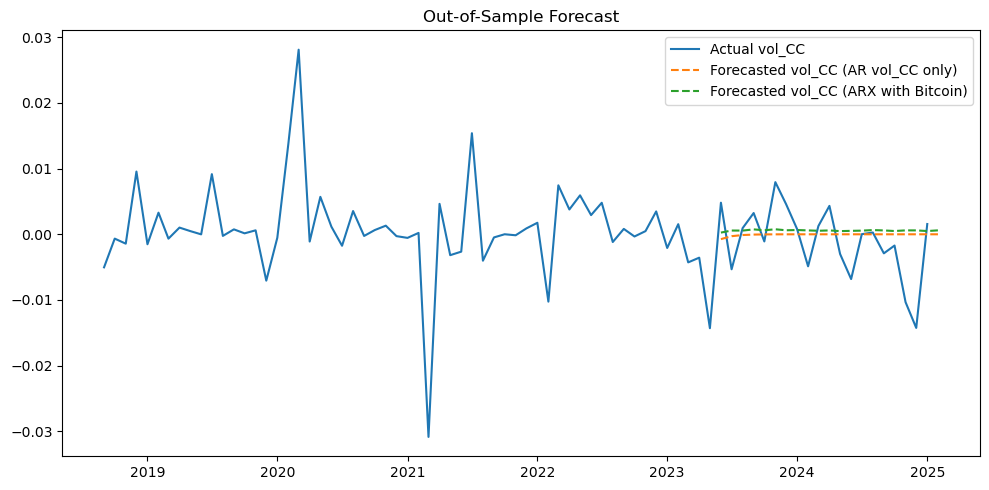

                               SARIMAX Results                                
Dep. Variable:            vol_CC_diff   No. Observations:                   57
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 199.521
Date:                Mon, 23 Jun 2025   AIC                           -393.041
Time:                        10:44:50   BIC                           -386.912
Sample:                    09-01-2018   HQIC                          -390.659
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3933      3.636      0.108      0.914      -6.734       7.521
ma.L1         -0.3473      3.642     -0.095      0.924      -7.486       6.792
sigma2      5.329e-05   5.53e-06      9.639      0.0

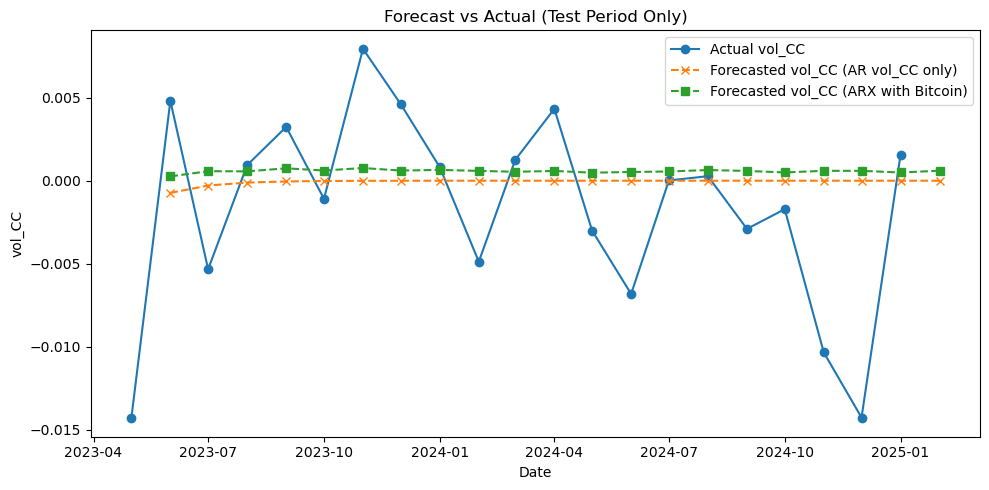

2023-06-01   -0.0007
2023-07-01   -0.0003
2023-08-01   -0.0001
2023-09-01   -0.0000
2023-10-01   -0.0000
2023-11-01   -0.0000
2023-12-01   -0.0000
2024-01-01   -0.0000
2024-02-01   -0.0000
2024-03-01   -0.0000
2024-04-01   -0.0000
2024-05-01   -0.0000
2024-06-01   -0.0000
2024-07-01   -0.0000
2024-08-01   -0.0000
2024-09-01   -0.0000
2024-10-01   -0.0000
2024-11-01   -0.0000
2024-12-01   -0.0000
2025-01-01   -0.0000
2025-02-01   -0.0000
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
available_cols = df.columns
if f'{macro}_diff_diff' in available_cols:
    target_col = f'{macro}_diff_diff'
elif f'{macro}_diff' in available_cols:
    target_col = f'{macro}_diff'
else:
    target_col = macro

df_temp = df[[target_col, asset]].dropna().copy()

### new
# df_temp['asset_lag1'] = df_temp[asset].shift(1)  # t-1
# df_temp['asset_lag2'] = df_temp[asset].shift(2)  # t-2 (optional)
# df_temp = df_temp.dropna()

target = df_temp[target_col]

exog = df_temp[[asset]]
# exog = df_temp[[asset, 'asset_lag1']].dropna()
# exog = df_temp[[asset, 'asset_lag1','asset_lag2']].dropna()
# exog = df_temp[[asset, 'LFPR', 'r']].dropna()


# Train/test split
train_endog = target[:train_end]
test_endog = target[train_end:]
train_exog = exog[:train_end]
test_exog = exog[train_end:]

order_dict = ar_orders.get(macro, {'p': 1, 'q': 0})  # Default to AR(1) if macro not found
p = order_dict['p']
q = order_dict['q']


# AR model
ar_model = SARIMAX(train_endog, order=(p, 0, q))
ar_result = ar_model.fit(disp=False)
forecast_ar = ar_result.get_forecast(steps=len(test_endog))
pred_ar = forecast_ar.predicted_mean
conf_int_ar = forecast_ar.conf_int() 

# ARX model
arx_model = SARIMAX(train_endog, exog=train_exog, order=(p, 0, q))
arx_result = arx_model.fit(disp=False)
forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
pred_arx = forecast_arx.predicted_mean
conf_int_arx = forecast_arx.conf_int()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro)
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--')
# plt.fill_between(
#     pred_ar.index,
#     conf_int_ar.iloc[:, 0],  # Lower bound
#     conf_int_ar.iloc[:, 1],   # Upper bound
#     color='blue',
#     alpha=0.1,
#     label='AR 95% CI'
# )
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--')
# plt.fill_between(
#     pred_arx.index,
#     conf_int_arx.iloc[:, 0],  # Lower bound
#     conf_int_arx.iloc[:, 1],  # Upper bound
#     color='red',
#     alpha=0.1,
#     label='ARX 95% CI'
# )
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Printing stats 
mae_ar = mean_absolute_error(test_endog, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_endog, pred_ar))
r2_ar = r2_score(test_endog, pred_ar)
print(ar_result.summary())
print(arx_result.summary())

mae_arx = mean_absolute_error(test_endog, pred_arx)
rmse_arx = np.sqrt(mean_squared_error(test_endog, pred_arx))
r2_arx = r2_score(test_endog, pred_arx)

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")

# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()